# xPTS

## Resultado según xG para un partido

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson

match = '4393624 Boca Juniors 4 v 2 Racing Club'
df_teams = pd.read_csv(match+' (teams).csv')

df_teams.insert(0, 'match_id', 4393624)


home = df_teams['team'][0]
away = df_teams['team'][1]
home_xg = df_teams['xG'][0]
away_xg = df_teams['xG'][1]

In [36]:
def simulate_match(home, away, home_xg, away_xg, max_goals=5, simulations=100000):
    
    # Calcular las medias de goles esperados para el equipo local y visitante
    home_mean_goals = home_xg
    away_mean_goals = away_xg
    
    # Lista para almacenar los resultados de cada simulación
    results = []

    # Realizar la simulación 'simulations' veces
    for _ in range(simulations):
        # Simular goles marcados por el equipo local y visitante en esta simulación
        home_goals = np.random.poisson(home_mean_goals)
        away_goals = np.random.poisson(away_mean_goals)
        
        # Asegurarse de que los goles no excedan el máximo permitido
        home_goals = min(home_goals, max_goals)
        away_goals = min(away_goals, max_goals)
        
        # Almacenar el resultado de esta simulación
        results.append((home_goals, away_goals))
    
    # Convertir resultados a un DataFrame de pandas para análisis posterior
    results_df = pd.DataFrame(results, columns=['home_goals', 'away_goals'])

    # Calcular la matriz de probabilidades de resultados esperados
    max_possible_goals = max_goals
    matrix = np.zeros((max_possible_goals + 1, max_possible_goals + 1))
    
    for index, row in results_df.iterrows():
        home_goals = row['home_goals']
        away_goals = row['away_goals']
        matrix[home_goals][away_goals] += 1
    
    matrix /= simulations
    
    # Crear un DataFrame de pandas para la matriz de probabilidades
    df_simulation = pd.DataFrame(matrix, index=range(max_possible_goals + 1), columns=range(max_possible_goals + 1))
    
    # Posibilidades de ganar de cada equipo
    home_win = np.sum(np.tril(matrix, -1))
    away_win = np.sum(np.triu(matrix, 1))
    draw = np.sum(np.diag(matrix))

    # Gráfico de heatmap utilizando seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_simulation, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
    plt.title(f"Probabilidades de resultados para {home} vs {away}", fontsize=14)
    plt.xlabel(away + " Goles", fontsize=12)
    plt.ylabel(home + " Goles", fontsize=12)
    plt.show()

    print(f'{home} tuvo {round(home_win*100,2)}% probabilidades de ganar.\n{away} tuvo {round(away_win*100,2)}% probabilidades de ganar.\nHubo {round(draw*100,2)}% de probabilidades de empate.')
    return

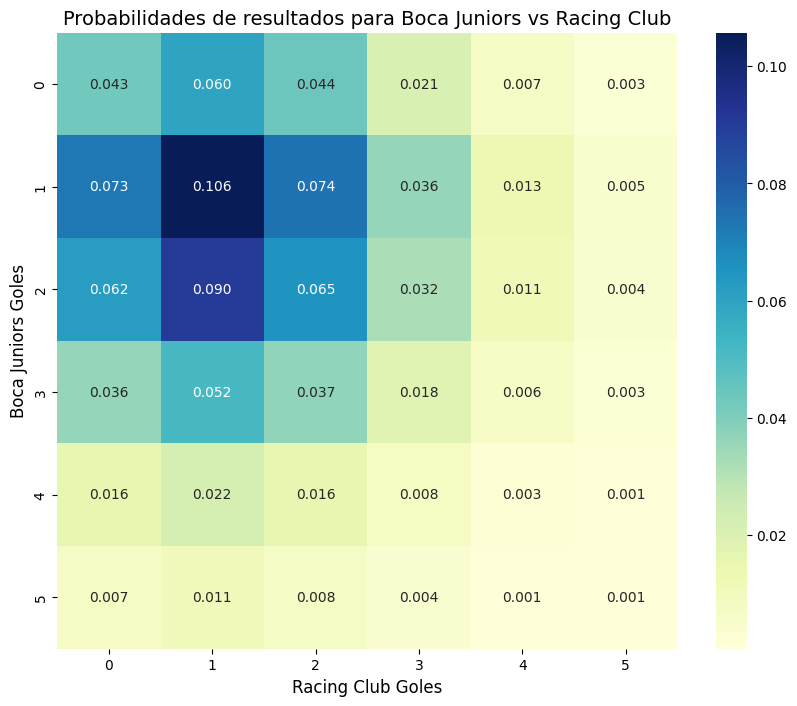

Boca Juniors tuvo 44.41% probabilidades de ganar.
Racing Club tuvo 32.04% probabilidades de ganar.
Hubo 23.55% de probabilidades de empate.


In [37]:
simulate_match(home, away, home_xg, away_xg)

## Puntos esperados en un torneo
Se necesita un dataframe de input con las columnas match_id, home, away, home_xg, away_xg

In [13]:
from prettytable import PrettyTable
import time

df_xpts = pd.DataFrame(columns=['match_id', 'team', 'xPts'])
num_simulations = 50000
n=0

for match_id in df_teams['match_id']:

    #print the simulation table and run simulations

    count_home_wins = 0
    count_home_loss = 0
    count_away_wins = 0
    count_away_loss = 0
    count_draws = 0
    score_mat = []
    tot_sim_time = 0

    #sim_table = PrettyTable(["N de Simulación #", input_home_team, input_away_team, "Loc Ganó", "Vis Ganó", "EMPATE", "DIF DE GOLES"])

    for i in range(num_simulations):
        #get simulation start time
        start_time = time.time()
        #run the sim - generate a random Poisson distribution
        target_home_goals_scored = np.random.poisson(home_xg)
        target_away_goals_scored = np.random.poisson(away_xg)
        home_win = 0
        away_win = 0
        draw = 0
        margin = 0

        # if more goals for home team => home team wins
        if target_home_goals_scored > target_away_goals_scored:
            count_home_wins += 1
            count_away_loss += 1
            home_win = 1
            margin = target_home_goals_scored - target_away_goals_scored
        # if more goals for away team => away team wins
        elif target_home_goals_scored < target_away_goals_scored:
            count_away_wins += 1
            count_home_loss += 1
            away_win = 1
            margin = target_away_goals_scored - target_home_goals_scored
        # if goals for home team = goals away team => draw
        elif target_home_goals_scored == target_away_goals_scored:
            draw = 1
            count_draws += 1
            margin = target_away_goals_scored - target_home_goals_scored

        # add score to score matrix
        score_mat.append((target_home_goals_scored, target_away_goals_scored))
        #get end time
        end_time = time.time()
        #add the time to the total simulation time
        tot_sim_time += round((end_time - start_time),5)
        #add the info to the simulation table
        #sim_table.add_row([i+1, target_home_goals_scored, target_away_goals_scored, home_win, away_win, draw, margin])
    # calculate probabilities to win/lose/draw
    #print(sim_table)

    home_win_probability = round((count_home_wins/num_simulations * 100),2)
    away_win_probability = round((count_away_wins/num_simulations * 100),2)
    draw_probability = round((count_draws/num_simulations * 100),2)

    sim_table_stats = PrettyTable(["Total # de sim", f"{home} gana", f"{away} gana", "Empates"])
    sim_table_stats.add_row([num_simulations, count_home_wins, count_away_wins, count_draws])
    sim_table_stats.add_row(["-", str(home_win_probability)+"%", str(away_win_probability)+"%", str(draw_probability)+"%"])
    #print(sim_table_stats)
    #print('-'*50)

    #calculate expected Pts and print a summary
    home_xPts = (home_win_probability / 100) * 3.0 + (draw_probability / 100) * 1.0 + (away_win_probability / 100) * 0.0
    away_xPts = (away_win_probability / 100) * 3.0 + (draw_probability / 100) * 1.0 + (home_win_probability / 100) * 0.0
    #print(home, "probabilidad de ganar %:", home_win_probability, "|| xPts =", round(home_xPts,2))
    #print(away, "probabilidad de ganar %:", away_win_probability, "|| xPts =", round(away_xPts,2))
    #print("Probabilidad de empate %:", draw_probability)
    lista = [match_id, home, home_xPts]
    lista2 = [match_id, away, away_xPts]
    df_xpts.loc[len(df_xpts)] = lista
    df_xpts.loc[len(df_xpts)] = lista2
    #print(df_xpts)
    #print('-'*50)
    n+=1
    print(match_id, n)

4393624 1
4393624 2


In [14]:
df_xpts.groupby('team').sum().sort_values(by='xPts', ascending=False)

,match_id,xPts
team,,
Boca Juniors,8787248,3.1371
Racing Club,8787248,2.3997
